# Flight scheduling optimization with RL

## Imports

In [1]:
import pandas as pd
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import NormalizeObservation, NormalizeReward
from pandas import Timestamp
import warnings

from schedule_optimizer.flight_scheduling import FlightSchedulingEnv
from schedule_optimizer.utils import generate_random_flight_schedule, generate_lambdas

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Simple case : 2 connecting flights

### Generate flight schedule and lambdas

In [2]:
schedule_0 = pd.DataFrame({
    'departure' : [Timestamp('1900-01-01 08:00:00'), Timestamp('1900-01-01 13:30:00')],
    'arrival' : [Timestamp('1900-01-01 10:00:00'), Timestamp('1900-01-01 14:30:00')],
    'way' : [-1, 1],
    'airport' : ['JFK', 'MAD'],
    'departure_minutes' : [480, 910],
    'arrival_minutes' : [600, 970],
})
schedule_0 

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 08:00:00,1900-01-01 10:00:00,-1,JFK,480,600
1,1900-01-01 13:30:00,1900-01-01 14:30:00,1,MAD,910,970


In [3]:
lambdas = generate_lambdas(schedule_0)
lambdas

{'JFKMAD': 1000, 'MADJFK': 1000}

### Custom environment

In [4]:
env = FlightSchedulingEnv(
    flight_schedule=schedule_0, 
    lambdas=lambdas, 
    max_steps=1000,
    revenue_estimation='classic',
    obs='cnx'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)
check_env(env)

### Random Policy

In [5]:
obs = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, truncated, _ = env.step(action)
    print(action)
    print("Observation:", obs, "Reward:", reward)

env.close()

4
Observation: [-0.25768915] Reward: 0.0
2
Observation: [-1.4727309] Reward: 27.7777777777776
1
Observation: [-2.26575222] Reward: 27.77777777777783
1
Observation: [-2.60875862] Reward: 27.77777777777783
0
Observation: [-1.54152496] Reward: -27.77777777777783
4
Observation: [-1.42586313] Reward: 0.0
2
Observation: [-2.00443255] Reward: 27.77777777777783
0
Observation: [-1.15364401] Reward: -27.77777777777783
4
Observation: [-1.09928565] Reward: 0.0
3
Observation: [-0.31609357] Reward: -27.77777777777783


### RL Policy

In [6]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

In [7]:
for _ in range(10):
    obs, _ = env.reset()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        '''if count < 9:
            action = 1
            count += 1
        else:
            action = 4
            count += 1'''
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    print(total_reward)
env.close()

250.0
250.0
250.0
250.0
250.0
222.22222222222217
250.0
250.0
250.0
250.0


### Tensorboard

In [ ]:
env = Monitor(env, 'logs/')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="logs/").learn(total_timesteps=100000)

In [ ]:
%tensorboard --logdir=logs/

## Random schedule

### Generating schedule and lambdas

In [195]:
random_schedule = generate_random_flight_schedule(100)
random_schedule

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 08:22:00,1900-01-01 10:42:00,1,FCO,502,642
1,1900-01-01 08:32:00,1900-01-01 10:52:00,-1,FCO,512,652
2,1900-01-01 08:32:00,1900-01-01 09:03:00,-1,JFK,512,543
3,1900-01-01 08:35:00,1900-01-01 10:43:00,1,FCO,515,643
4,1900-01-01 08:37:00,1900-01-01 10:47:00,1,JFK,517,647
...,...,...,...,...,...,...
95,1900-01-01 21:04:00,1900-01-01 21:53:00,1,JFK,1264,1313
96,1900-01-01 21:14:00,1900-01-01 21:58:00,1,FCO,1274,1318
97,1900-01-01 21:16:00,1900-01-01 22:58:00,-1,JFK,1276,1378
98,1900-01-01 21:35:00,1900-01-01 23:07:00,1,FCO,1295,1387


In [196]:
perfect_schedule = random_schedule.copy()
perfect_schedule.loc[perfect_schedule['way']==-1, "arrival_minutes"] = 680
perfect_schedule.loc[perfect_schedule['way']==1, "departure_minutes"] = 800
perfect_schedule.loc[perfect_schedule['way']==1, "arrival_minutes"] = 1000
perfect_schedule.loc[perfect_schedule['way']==-1, "departure_minutes"] = 400

In [197]:
random_lambdas = generate_lambdas(random_schedule)
random_lambdas

{'FCOJFK': 1000,
 'JFKFCO': 1000,
 'FCOMAD': 1000,
 'MADFCO': 1000,
 'JFKMAD': 1000,
 'MADJFK': 1000}

### Custom environment

In [198]:
env = FlightSchedulingEnv(
    flight_schedule=random_schedule,
    lambdas=random_lambdas,
    max_steps=1000,
    revenue_estimation='classic'
)
perfect_env = FlightSchedulingEnv(
    flight_schedule=perfect_schedule,
    lambdas=random_lambdas,
    max_steps=1000,
    revenue_estimation='classic'
)
env = NormalizeObservation(env)
env = NormalizeReward(env)
check_env(env)

In [200]:
perfect_env.calculate_revenue()

1674000.0

In [201]:
random_schedule

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 08:22:00,1900-01-01 10:42:00,1,FCO,502,642
1,1900-01-01 08:32:00,1900-01-01 10:52:00,-1,FCO,512,652
2,1900-01-01 08:32:00,1900-01-01 09:03:00,-1,JFK,512,543
3,1900-01-01 08:35:00,1900-01-01 10:43:00,1,FCO,515,643
4,1900-01-01 08:37:00,1900-01-01 10:47:00,1,JFK,517,647
...,...,...,...,...,...,...
95,1900-01-01 21:04:00,1900-01-01 21:53:00,1,JFK,1264,1313
96,1900-01-01 21:14:00,1900-01-01 21:58:00,1,FCO,1274,1318
97,1900-01-01 21:16:00,1900-01-01 22:58:00,-1,JFK,1276,1378
98,1900-01-01 21:35:00,1900-01-01 23:07:00,1,FCO,1295,1387


In [202]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

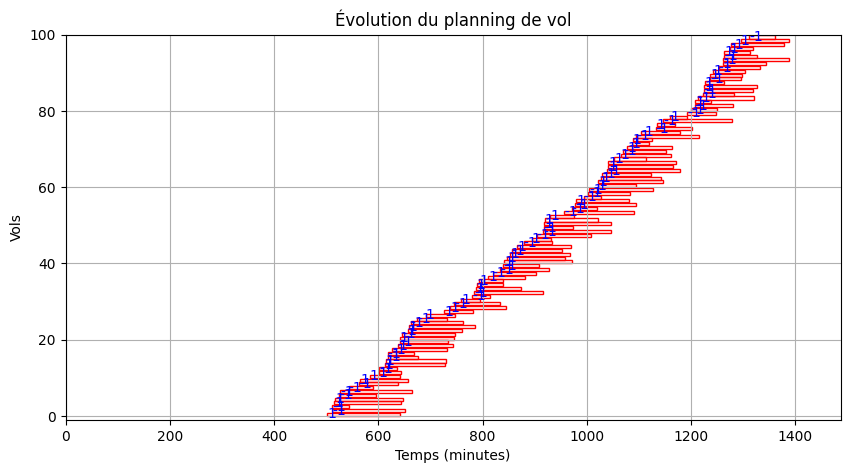

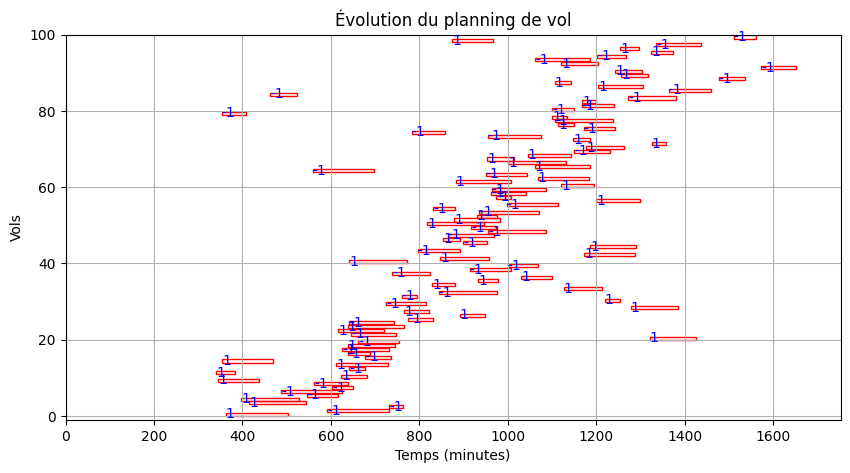

17.107807486899343


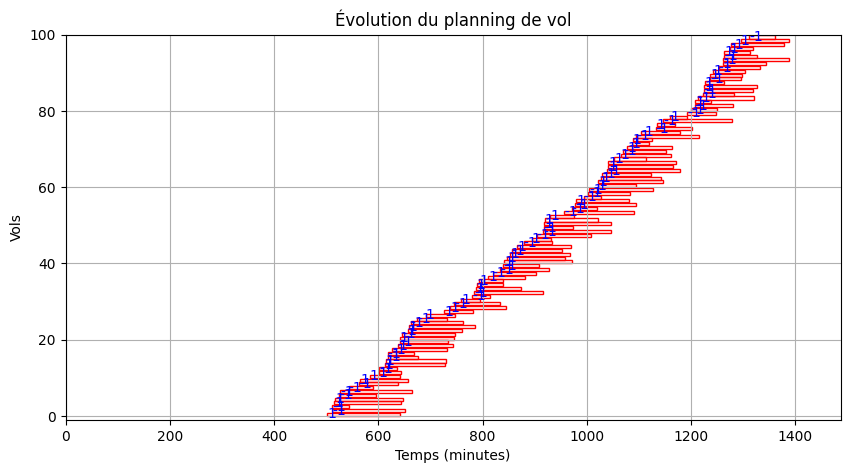

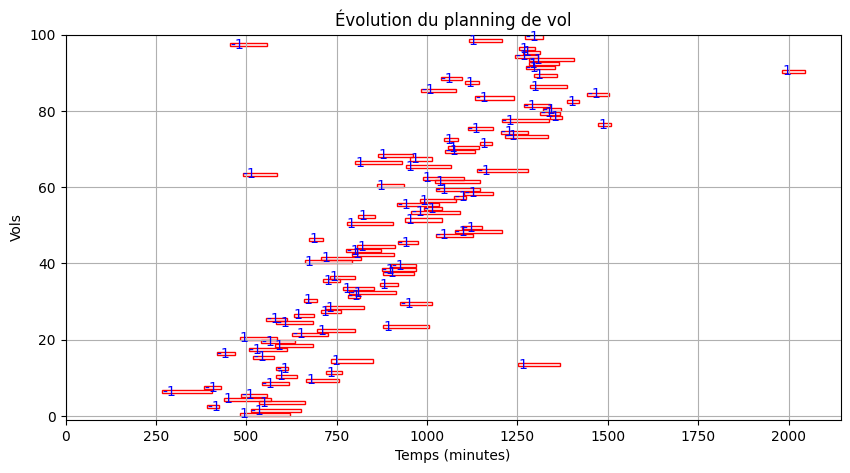

1.4188568443226643


In [205]:
for _ in range(2):
    obs, _ = env.reset()
    env.renderer()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    env.renderer()
    print(total_reward)
env.close()

### Tensorboard

In [5]:
env = Monitor(env, 'logs/')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="logs/").learn(total_timesteps=100000)

In [ ]:
%tensorboard --logdir=logs/